# Script to analyze the gene expression over different bins
### Genome Analysis Project, VT24

**Last Changed:** 2024-05-09

## Read the data

In [1]:
# Import the necessary packages
import os
import pandas as pd

In [2]:
# Define the path to the directory containing the data files (.tsv format)
directory = '/Users/claranordquist/Documents/Universitetet/VT/Genome_Analysis/Lab_Project/Feature_analysis/'

# Create a dictionary where all the dataframes will be stored for each bin
bin_dataframes = {}

# Loop over the files in the input directory and pick those that end with .tsv
# For those, read the files and make them into dataframes
# Add a column for the bin name
for file in os.listdir(directory):
    if file.endswith('.tsv'):
        basename = file[:-4]
        bin_dataframes[basename] = pd.read_table(os.path.join(directory, file), sep='\t')
        bin_dataframes[basename].insert(0, 'Count', bin_dataframes[basename].index)
        bin_dataframes[basename].insert(0, 'Bin', basename)

# Insert a new column where the counts are normalized to relative numbers instead of absolute
# That is, divided by the total number of counts for each bin and environment
for sample in bin_dataframes.keys():
    bin_dataframes[sample]['Relative_count'] = bin_dataframes[sample]['Count'] / bin_dataframes[sample].sum()['Count']

## Basic Analyses

### Histogram of counts per gene

Text(0, 0.5, 'N° genes')

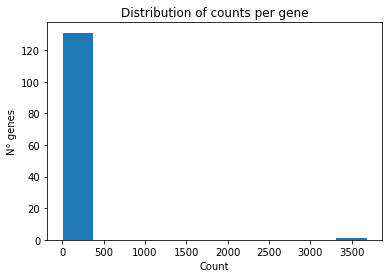

In [13]:
# Make a histogram with counts per gene for one sample
import matplotlib.pyplot as plt

sample = bin_dataframes['Bin_4_SRR4342139']

plt.hist(sample['Count'])
plt.title('Distribution of counts per gene')
plt.xlabel('Count')
plt.ylabel('N° genes')

### Statistics on number of reads

In [16]:
# Get statistics on the number of genes, unique genes, genes with a name, and genes with COG classification
for sample, data in bin_dataframes.items():
    n_hypothetical = len(data[data['COG_category'] != '-'])
    name_hypothetical = len(data[data['Preferred_name'] != '-'])
    # print()
    print(sample)
    print(f'N° different genes: {len(data)}, N° genes: {data["Count"].sum()}, N° genes with name: {name_hypothetical}, N° genes with COG: {n_hypothetical}')
    print()

Bin_15_SRR4342137
N° different genes: 122, N° genes: 488, N° genes with name: 89, N° genes with COG: 120

Bin_20_SRR4342139
N° different genes: 128, N° genes: 480, N° genes with name: 43, N° genes with COG: 122

Bin_19_SRR4342137
N° different genes: 366, N° genes: 1790, N° genes with name: 202, N° genes with COG: 355

Bin_4_SRR4342137
N° different genes: 391, N° genes: 9336, N° genes with name: 184, N° genes with COG: 370

Bin_19_SRR4342139
N° different genes: 774, N° genes: 6020, N° genes with name: 430, N° genes with COG: 750

Bin_4_SRR4342139
N° different genes: 132, N° genes: 4832, N° genes with name: 62, N° genes with COG: 125

Bin_20_SRR4342137
N° different genes: 143, N° genes: 978, N° genes with name: 45, N° genes with COG: 138

Bin_15_SRR4342139
N° different genes: 433, N° genes: 2322, N° genes with name: 251, N° genes with COG: 413



### Heatmap of energy production genes
Display the gene expression of genes in the COG category "C" (energy production and conversion) through a heatmap

In [3]:
# Import the necessary libraries
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

In [4]:
# Pool the data into one dataframe for all bins and environments
# Select genes that are in the C COG category (energy production and conversion)
# Use the relative count to create a heatmap for the different bins/environments

# First, select the relevant columns from the original datasets
# Then, reset the index
# Thereafter, drop the columns which have no gene name
# Lastly, select only genes that are classified as C in the COG categorization
heatmap_dataframe = pd.concat([bin_dataframes[x][['Bin', 'Relative_count', 'Preferred_name', 'COG_category']] for x in bin_dataframes.keys()], axis=0)
heatmap_dataframe.reset_index(drop=True, inplace=True)
heatmap_dataframe.drop(heatmap_dataframe.loc[heatmap_dataframe['Preferred_name'] == '-'].index, inplace=True)
heatmap_dataframe = heatmap_dataframe.loc[heatmap_dataframe['COG_category'].str.contains('C'), :]

# Convert it to a pivot table telling how I want the heatmap (columns = genes, rows = bins, values = relative count)
pivot_table = pd.pivot_table(data=heatmap_dataframe, columns='Preferred_name', index='Bin', values='Relative_count')

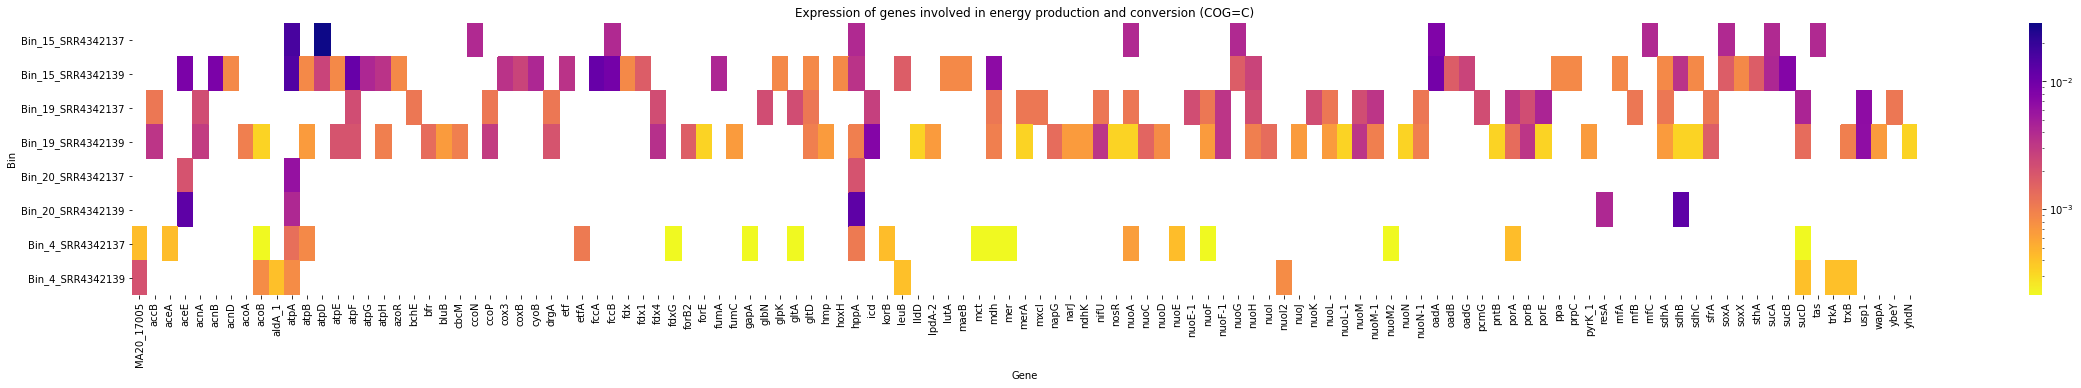

In [10]:
# Plot the heatmap
# The color scale is logarithmic
plt.figure(figsize = (40,5))
sns.heatmap(pivot_table, cmap='plasma_r', norm=LogNorm())
plt.xlabel('Gene')
plt.title('Expression of genes involved in energy production and conversion (COG=C)')
plt.show()

## Extra Analysis

### COG Categories
Look at how the expression of the different COG categories across different environments for all bins

In [11]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# First, create new datasets with only the bin name, count, and COG category
# Reset the index
bins_COG = {}
for sample, data in bin_dataframes.items():
    bins_COG[sample] = data[['Bin', 'Relative_count', 'COG_category']]
    bins_COG[sample].reset_index(drop=True, inplace=True)

# Remove all genes that don't have a COG category
for data in bins_COG.values():
    data.drop(data.loc[data['COG_category'] == '-'].index, inplace=True)

# Collect all values for the individual COG codes, so that they are in the same row (one row per category)
aggregate_function = {"Bin":'first', "Relative_count":'sum', "COG_category":'first'}
for sample in bins_COG.keys():
    bins_COG[sample] = bins_COG[sample].groupby(bins_COG[sample]['COG_category']).aggregate(aggregate_function)

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_878/4225281126.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(data.loc[data['COG_category'] == '-'].index, inplace=True)


In [13]:
# For each of the bins and environments:
# Resolve all genes which have multiple COG categories
# Remove those entries, and replace them with +the count on the count for each COG category
# Store the results in a new (nested) dictionary with the count values for each category

# Templete for the COG count dictionaries, containing all COG categories
count_dict = {'A':0, 'B':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 'H':0, 'I':0, 'J':0, 'K':0, 'L':0,
              'M':0, 'N':0, 'O':0, 'P':0, 'Q':0, 'T':0, 'U':0, 'V':0, 'Y':0, 'Z':0, 'R':0, 'S':0}

COG_counts = {}
for sample in bin_dataframes.keys():
    COG_counts[sample] = count_dict.copy()

# Iterate over all rows (genes)
    for index, row in bins_COG[sample].iterrows():
        COG = row['COG_category']

# If the COG category is just one letter
        if len(COG) == 1:
            COG_counts[sample][COG] = bins_COG[sample].loc[COG]['Relative_count']

# If the COG category is of two or more letters (= multiple categories)
        if len(COG) > 1:
            for category in list(COG):
                COG_counts[sample][category] += bins_COG[sample].loc[COG]['Relative_count']

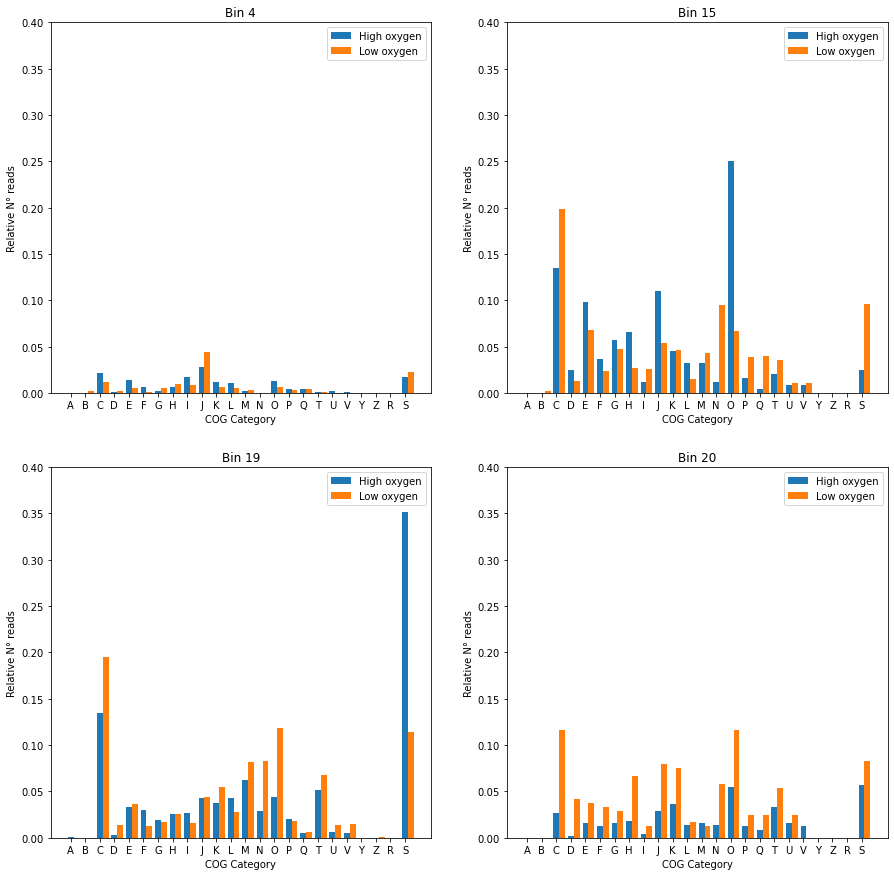

In [17]:
# Plot the results
x_values = np.arange(len(count_dict.keys()))
x_labels = [a for a in count_dict.keys()]
w = 0.4
ymax = 0.4

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.title('Bin 4')
plt.bar(x_values, COG_counts['Bin_4_SRR4342137'].values(), width=w, label='High oxygen')
plt.bar(x_values + w, COG_counts['Bin_4_SRR4342139'].values(), width=w, label='Low oxygen')
plt.xticks(x_values, labels=x_labels)
plt.ylim([0, ymax])
plt.legend()
plt.xlabel('COG Category')
plt.ylabel('Relative N° reads')

plt.subplot(2, 2, 2)
plt.title('Bin 15')
plt.bar(x_values, COG_counts['Bin_15_SRR4342137'].values(), width=w, label='High oxygen')
plt.bar(x_values + w, COG_counts['Bin_15_SRR4342139'].values(), width=w, label='Low oxygen')
plt.xticks(x_values, labels=x_labels)
plt.ylim([0, ymax])
plt.legend()
plt.xlabel('COG Category')
plt.ylabel('Relative N° reads')

plt.subplot(2, 2, 3)
plt.title('Bin 19')
plt.bar(x_values, COG_counts['Bin_19_SRR4342137'].values(), width=w, label='High oxygen')
plt.bar(x_values + w, COG_counts['Bin_19_SRR4342139'].values(), width=w, label='Low oxygen')
plt.xticks(x_values, labels=x_labels)
plt.ylim([0, ymax])
plt.legend()
plt.xlabel('COG Category')
plt.ylabel('Relative N° reads')

plt.subplot(2, 2, 4)
plt.title('Bin 20')
plt.bar(x_values, COG_counts['Bin_20_SRR4342137'].values(), width=w, label='High oxygen')
plt.bar(x_values + w, COG_counts['Bin_20_SRR4342139'].values(), width=w, label='Low oxygen')
plt.xticks(x_values, labels=x_labels)
plt.ylim([0, ymax])
plt.legend()
plt.xlabel('COG Category')
plt.ylabel('Relative N° reads')

plt.show()

### Abundance Data

In [1]:
# Import the libraries
import pandas as pd

In [32]:
# Add the data (N° DNA reads) for the bins and environments
# Low Oxygen = SRR4342133
# High Oxygen = SRR4342129

abundance_data = pd.DataFrame([159631, 871694, 475534, 1072266], index=['Bin 4', 'Bin 15', 'Bin 19', 'Bin 20'], columns=['Low Oxygen'])
abundance_data['High Oxygen'] = [371862, 71414, 50279, 403094]

# Normalize the values to get the percentage of the different bins
abundance_data['Low Oxygen'] = abundance_data['Low Oxygen'] / abundance_data['Low Oxygen'].sum()
abundance_data['High Oxygen'] = abundance_data['High Oxygen'] / abundance_data['High Oxygen'].sum()

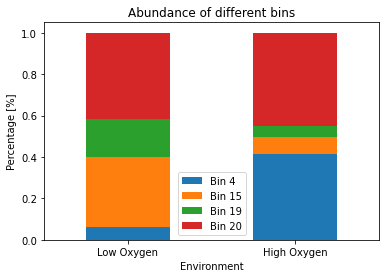

In [39]:
# Plot
abundance_data.transpose().plot(kind='bar', stacked=True)
plt.title('Abundance of different bins')
plt.xticks(rotation=0)
plt.ylabel('Percentage [%]')
plt.xlabel('Environment')
plt.show()